# Fragrantica Master CSV — Analysis
Statistics and exploratory analysis of `Saved Data/all_brands_clean.csv`.

In [8]:
import pandas as pd
from pathlib import Path

MASTER_CSV = Path("../Saved Data/all_brands_clean.csv")

df = pd.read_csv(MASTER_CSV, encoding="utf-8-sig")
print(f"Loaded {len(df):,} rows, {df['brand'].nunique():,} unique brands")
df.head(3)

Loaded 13,494 rows, 153 unique brands


,brand,name,rating,votes,url,last_crawled,sex,fragrance_category
0,4711,Acqua Colonia Bamboo & Watermelon,3.56,87,https://www.fragrantica.com/perfume/4711/4711-...,2026-01-02T18:29:03.414305,unisex,Aromatic
1,4711,Acqua Colonia Blackberry & Cocoa,3.89,74,https://www.fragrantica.com/perfume/4711/4711-...,2026-02-05T21:04:58.042871,unisex,Floral Fruity Gourmand
2,4711,Acqua Colonia Blood Orange & Basil,4.11,1113,https://www.fragrantica.com/perfume/4711/4711-...,2026-01-02T18:08:46.565085,unisex,Citrus Aromatic


## `sex` column — unique values & counts
The three expected values are `women`, `men`, and `unisex`. Any other value is dirty data scraped from the wrong field.

In [9]:
CLEAN_VALUES = {"women", "men", "unisex"}

sex_counts = df["sex"].fillna("").str.strip().value_counts(dropna=False)

clean_mask = sex_counts.index.isin(CLEAN_VALUES)
clean   = sex_counts[clean_mask]
dirty   = sex_counts[~clean_mask]

total        = len(df)
clean_total  = clean.sum()
dirty_total  = dirty.sum()

print("=" * 50)
print(f"Total rows       : {total:>6,}")
print(f"Clean sex values : {clean_total:>6,}  ({clean_total/total*100:.1f}%)")
print(f"Dirty sex values : {dirty_total:>6,}  ({dirty_total/total*100:.1f}%)")
print()

print("--- Clean values ---")
for val, cnt in clean.items():
    label = val if val != "" else "(empty)"
    print(f"  {label:<10} {cnt:>6,}  ({cnt/total*100:.1f}%)")

print()
print(f"--- Dirty values ({len(dirty)} unique) ---")
for val, cnt in dirty.items():
    label = (val[:80] + "…") if len(val) > 80 else val
    label = label if label != "" else "(empty)"
    print(f"  [{cnt:>3}]  {label}")

Total rows       : 13,494
Clean sex values : 13,437  (99.6%)
Dirty sex values :     57  (0.4%)

--- Clean values ---
  unisex      6,161  (45.7%)
  women       5,168  (38.3%)
  men         2,108  (15.6%)

--- Dirty values (1 unique) ---
  [ 57]  (empty)


## `sex` column — clean dirty values

Rules applied in order (order matters — "women" contains "men"):
1. substring `"men and women"` → `"unisex"`
2. substring `"women"` / `"Women"` → `"women"`
3. substring `"men"` / `"Men"` → `"men"`

Rows that don't match any rule are left unchanged and reported.

In [4]:
import pandas as pd
from pathlib import Path

MASTER_CSV = Path("../Saved Data/all_brands_clean.csv")
CLEAN_VALUES = {"women", "men", "unisex"}

df_clean = pd.read_csv(MASTER_CSV, encoding="utf-8-sig")

def infer_sex(value: str) -> str | None:
    """Map a dirty sex string to a canonical value, or None if unresolvable."""
    v = str(value).strip()
    if v in CLEAN_VALUES:
        return v
    # Order matters: check "men and women" before "women", "women" before "men"
    if "men and women" in v or "Men and Women" in v:
        return "unisex"
    if "women" in v or "Women" in v:
        return "women"
    if "men" in v or "Men" in v:
        return "men"
    return None

original_sex = df_clean["sex"].copy()
df_clean["sex"] = df_clean["sex"].fillna("").apply(infer_sex).combine_first(df_clean["sex"])

fixed_mask = (original_sex != df_clean["sex"]) & ~original_sex.isin(CLEAN_VALUES)
unresolved = df_clean.loc[~df_clean["sex"].isin(CLEAN_VALUES), ["brand", "name", "sex"]]

print(f"Fixed     : {fixed_mask.sum()} rows")
print(f"Unresolved: {len(unresolved)} rows\n")

if fixed_mask.any():
    print("--- Fixes applied ---")
    for orig, new in zip(original_sex[fixed_mask], df_clean["sex"][fixed_mask]):
        print(f"  {repr(orig)[:70]:<72} → {new}")

if not unresolved.empty:
    print("\n--- Still unresolved (left unchanged) ---")
    print(unresolved.to_string(index=False))

# Save back to master CSV
df_clean.to_csv(MASTER_CSV, index=False, encoding="utf-8-sig")
print(f"\nSaved {len(df_clean):,} rows to {MASTER_CSV}")

# Keep df in sync if setup cell was also run
try:
    df["sex"] = df_clean["sex"]
except NameError:
    pass

Fixed     : 79 rows
Unresolved: 57 rows

--- Fixes applied ---
  'Fall & winter that always gets compliments when I wear it'              → men
  'men presented on the market in 2010'                                    → men
  'women to be launched in 2011'                                           → women
  'men introduced in 2010'                                                 → men
  'women set to be released in 2025'                                       → women
  'men Champion Energy'                                                    → men
  'men launched in 2025'                                                   → men
  'women introduced in 2007'                                               → women
  'men and women'                                                          → unisex
  "men that is quite old-school and in line with Floris' roots and begin   → men
  'men that evokes the power and beauty of the sea with its marine notes   → men
  'men built around aromatic'        

In [7]:
import pandas as pd
import numpy as np
from pathlib import Path

MASTER_CSV = Path("../Saved Data/all_brands_clean.csv")
CLEAN_VALUES = {"women", "men", "unisex"}

df_null = pd.read_csv(MASTER_CSV, encoding="utf-8-sig")

dirty_mask = ~df_null["sex"].isin(CLEAN_VALUES)
nullified = df_null.loc[dirty_mask, ["brand", "name", "sex"]].copy()

df_null.loc[dirty_mask, "sex"] = np.nan

print(f"Nullified : {dirty_mask.sum()} rows\n")
if not nullified.empty:
    print("--- Rows set to NaN ---")
    print(nullified.to_string(index=False))

df_null.to_csv(MASTER_CSV, index=False, encoding="utf-8-sig")
print(f"\nSaved {len(df_null):,} rows to {MASTER_CSV}")

Nullified : 57 rows

--- Rows set to NaN ---
                   brand                                     name                                                                                                                                                                                                                                                              sex
    Al Haramain Perfumes                         Coupe Pour Homme                                                                                                                                                                                                                                                        its price
                 Amouage                            Bracken Woman                                                                                                                                                                                                                                a woman who is untam

## Analizing and visualizing the cathegories of fragrances

In [33]:
import pandas as pd
from pathlib import Path

# Set up your file paths
MASTER_CSV = Path("../Saved Data/all_brands_clean.csv")
# Creating an output file so you don't lose the data if the terminal cuts it off
OUTPUT_TXT = Path("../Saved Data/category_analysis_output.txt") 

# Read the master dataset
df_cat = pd.read_csv(MASTER_CSV, encoding="utf-8-sig")

total = len(df_cat)

# Clean the column: fill NaNs, make sure everything is a string, and strip extra spaces
df_cat["fragrance_category"] = df_cat["fragrance_category"].fillna("(empty)").astype(str).str.strip()

# Calculate the counts for every single category
cat_counts = df_cat["fragrance_category"].value_counts(dropna=False)

# Prepare the summary strings
summary_lines = [
    f"Total rows          : {total:,}",
    f"Unique categories   : {len(cat_counts)}",
    f"Missing (NaN/empty) : {len(df_cat[df_cat['fragrance_category'] == '(empty)'])}",
    "",
    # Widened the category column to 60 characters to fit long fragrance descriptions
    f"{'Category':<60} {'Count':>8}  {'%':>6}",
    "-" * 78
]

# Print the summary to the screen
for line in summary_lines:
    print(line)

# Print ALL values to the screen and collect them to save
output_data = summary_lines.copy()

for cat, cnt in cat_counts.items():
    # Convert category to string just in case, and format the row
    cat_str = str(cat)
    
    # If the category name is ridiculously long, we cap it at 58 characters for neatness
    if len(cat_str) > 58:
        cat_str = cat_str[:55] + "..."
        
    row_str = f"{cat_str:<60} {cnt:>8,}  {cnt/total*100:>5.1f}%"
    print(row_str)
    output_data.append(row_str)

# Save the exact output to a text file so you can view ALL of it easily
try:
    with open(OUTPUT_TXT, "w", encoding="utf-8") as f:
        f.write("\n".join(output_data))
    print(f"\n✅ Full analysis successfully saved to: {OUTPUT_TXT}")
except Exception as e:
    print(f"\n⚠️ Could not save to text file: {e}")

Total rows          : 13,494
Unique categories   : 33
Missing (NaN/empty) : 1440

Category                                                        Count       %
------------------------------------------------------------------------------
(empty)                                                         1,440   10.7%
Floral                                                          1,384   10.3%
Oriental Floral                                                 1,377   10.2%
Floral Fruity                                                     988    7.3%
Oriental Woody                                                    937    6.9%
Floral Woody Musk                                                 687    5.1%
Oriental                                                          633    4.7%
Woody Aromatic                                                    585    4.3%
Oriental Vanilla                                                  543    4.0%
Woody Spicy                                                

In [22]:
import pandas as pd
import numpy as np
from pathlib import Path

MASTER_CSV = Path("../Saved Data/all_brands_clean.csv")

EXTRA_DIRTY = {'Oh Wow', '"Oh Wow"', "10/10 ", "10/10"}  # known bad values (strip-safe)

df_fc = pd.read_csv(MASTER_CSV, encoding="utf-8-sig")

# Nullify values that start with a lowercase letter OR are known dirty strings
dirty_mask = df_fc["fragrance_category"].notna() & (
    df_fc["fragrance_category"].str.match(r'^[a-z]') |
    df_fc["fragrance_category"].str.strip().isin(EXTRA_DIRTY)
)
nullified = df_fc.loc[dirty_mask, ["brand", "name", "fragrance_category"]].copy()

df_fc.loc[dirty_mask, "fragrance_category"] = np.nan

print(f"Nullified : {dirty_mask.sum()} rows\n")
if not nullified.empty:
    print("--- Rows set to NaN ---")
    print(nullified.to_string(index=False))

df_fc.to_csv(MASTER_CSV, index=False, encoding="utf-8-sig")
print(f"\nSaved {len(df_fc):,} rows to {MASTER_CSV}")

Nullified : 1 rows

--- Rows set to NaN ---
       brand        name fragrance_category
Serge Lutens L'orpheline           "Oh Wow"

Saved 13,494 rows to ../Saved Data/all_brands_clean.csv


## `fragrance_category` — Visualizations
Three versions: **① static bar chart** → **② interactive treemap** → **③ interactive sunburst** (most insightful).  
All exclude the `(empty)` bucket so only real categories are plotted.

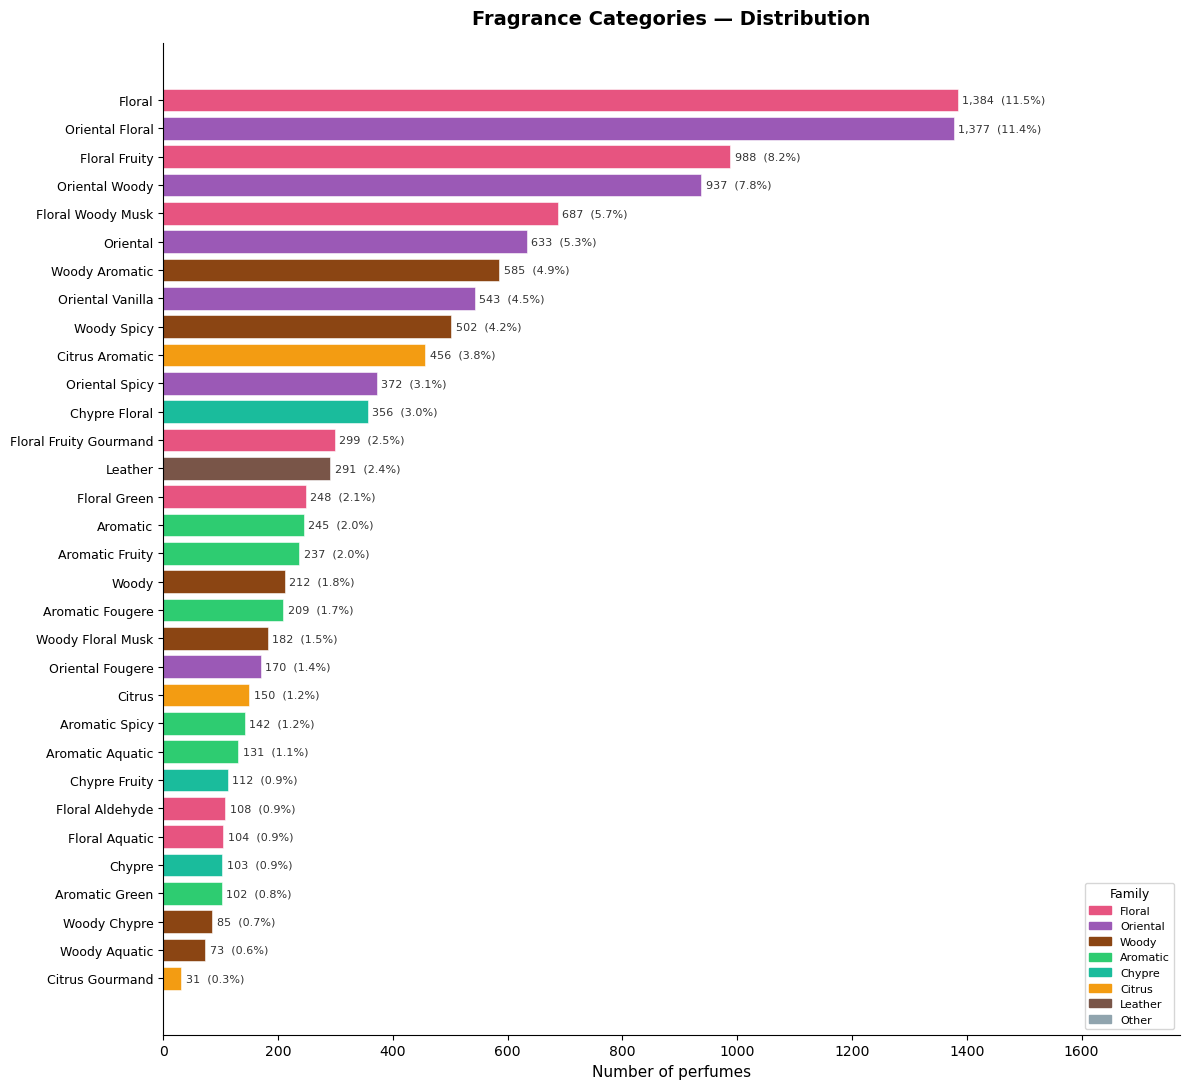

Saved → fragrance_category_bar.png


In [24]:
# ── Version 1: Static horizontal bar chart, colour-coded by fragrance family ──
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path

MASTER_CSV = Path("../Saved Data/all_brands_clean.csv")

FAMILY_COLORS = {
    "Floral":    "#e75480",
    "Oriental":  "#9b59b6",
    "Woody":     "#8B4513",
    "Aromatic":  "#2ecc71",
    "Chypre":    "#1abc9c",
    "Citrus":    "#f39c12",
    "Leather":   "#795548",
}
DEFAULT_COLOR = "#90a4ae"

df_v = pd.read_csv(MASTER_CSV, encoding="utf-8-sig")
counts = (
    df_v["fragrance_category"]
    .dropna()
    .str.strip()
    .value_counts()
    .sort_values()          # ascending → longest bar at top
)

def family_color(label):
    for fam, col in FAMILY_COLORS.items():
        if label.startswith(fam):
            return col
    return DEFAULT_COLOR

colors = [family_color(c) for c in counts.index]
total  = counts.sum()

fig, ax = plt.subplots(figsize=(12, 11))
bars = ax.barh(counts.index, counts.values, color=colors, edgecolor="white", linewidth=0.4)

# Annotate each bar with count + %
for bar, val in zip(bars, counts.values):
    ax.text(bar.get_width() + 8, bar.get_y() + bar.get_height() / 2,
            f"{val:,}  ({val/total*100:.1f}%)",
            va="center", ha="left", fontsize=8, color="#333333")

ax.set_xlabel("Number of perfumes", fontsize=11)
ax.set_title("Fragrance Categories — Distribution", fontsize=14, fontweight="bold", pad=14)
ax.set_xlim(0, counts.max() * 1.28)
ax.spines[["top", "right"]].set_visible(False)
ax.tick_params(axis="y", labelsize=9)

legend_handles = [mpatches.Patch(color=col, label=fam) for fam, col in FAMILY_COLORS.items()]
legend_handles.append(mpatches.Patch(color=DEFAULT_COLOR, label="Other"))
ax.legend(handles=legend_handles, title="Family", loc="lower right",
          fontsize=8, title_fontsize=9, framealpha=0.8)

plt.tight_layout()
plt.savefig("fragrance_category_bar.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved → fragrance_category_bar.png")


In [29]:
# ── Version 2: Interactive Plotly treemap ──
import pandas as pd
import plotly.express as px
from pathlib import Path

MASTER_CSV = Path("../Saved Data/all_brands_clean.csv")

FAMILY_COLORS = {
    "Floral":   "#e75480",
    "Oriental": "#9b59b6",
    "Woody":    "#8B4513",
    "Aromatic": "#2ecc71",
    "Chypre":   "#1abc9c",
    "Citrus":   "#f39c12",
    "Leather":  "#795548",
    "Other":    "#90a4ae",
}

df_v = pd.read_csv(MASTER_CSV, encoding="utf-8-sig")

counts = (
    df_v["fragrance_category"]
    .dropna()
    .str.strip()
    .value_counts()
    .reset_index()
)
counts.columns = ["category", "count"]
total = counts["count"].sum()
counts["pct"] = (counts["count"] / total * 100).round(1)

def get_family(label):
    families = ["Floral", "Oriental", "Woody", "Aromatic", "Chypre", "Citrus", "Leather"]
    for f in families:
        if label.startswith(f):
            return f
    return "Other"

counts["family"] = counts["category"].apply(get_family)
counts["color"]  = counts["family"].map(FAMILY_COLORS)

fig = px.treemap(
    counts,
    path=["family", "category"],
    values="count",
    color="family",
    color_discrete_map=FAMILY_COLORS,
    custom_data=["count", "pct"],
    title="Fragrance Categories — Treemap by Family",
)

fig.update_traces(
    hovertemplate=(
        "<b>%{label}</b><br>"
        "Count: %{customdata[0]:,}<br>"
        "Share: %{customdata[1]:.1f}%<extra></extra>"
    ),
    texttemplate="<b>%{label}</b><br>%{customdata[1]:.1f}%",
    textfont_size=13,
)

fig.update_layout(
    margin=dict(t=50, l=10, r=10, b=10),
    height=650,
)

fig.show()


In [34]:
import pandas as pd
import plotly.graph_objects as go
from pathlib import Path

MASTER_CSV = Path("../Saved Data/all_brands_clean.csv")

FAMILY_COLORS = {
    "Floral":   "#e75480",
    "Oriental": "#9b59b6",
    "Woody":    "#a0522d",
    "Aromatic": "#27ae60",
    "Chypre":   "#1abc9c",
    "Citrus":   "#f39c12",
    "Leather":  "#795548",
    "Other":    "#90a4ae",
}

df_v = pd.read_csv(MASTER_CSV, encoding="utf-8-sig")

cat_counts = (
    df_v["fragrance_category"]
    .dropna()
    .str.strip()
    .value_counts()
    .reset_index()
)
cat_counts.columns = ["category", "count"]
total = cat_counts["count"].sum()

FAMILIES = ["Floral", "Oriental", "Woody", "Aromatic", "Chypre", "Citrus", "Leather"]

def get_family(label):
    for f in FAMILIES:
        if label.startswith(f):
            return f
    return "Other"

cat_counts["family"] = cat_counts["category"].apply(get_family)

# Aggregate family totals for the inner ring
family_totals = cat_counts.groupby("family")["count"].sum().reset_index()

# Build sunburst data manually
# ADDED: an `ids` list to prevent duplicate label conflicts
ids, labels, parents, values, colors, hovers = [], [], [], [], [], []

# Root node (invisible centre)
ids.append("All")
labels.append("All")
parents.append("")
values.append(total)
colors.append("#ffffff")
hovers.append("")

# Inner ring — families
for _, row in family_totals.iterrows():
    fam   = row["family"]
    cnt   = row["count"]
    pct   = cnt / total * 100
    
    ids.append(f"Family_{fam}")     # Give the family a unique ID
    labels.append(fam)
    parents.append("All")           # Points to the root ID
    values.append(cnt)
    colors.append(FAMILY_COLORS.get(fam, "#90a4ae"))
    hovers.append(f"<b>{fam}</b><br>{cnt:,} perfumes<br>{pct:.1f}% of total")

# Outer ring — individual categories
for _, row in cat_counts.iterrows():
    cat = row["category"]
    cnt = row["count"]
    fam = row["family"]
    pct_total  = cnt / total * 100
    fam_total  = family_totals.loc[family_totals["family"] == fam, "count"].values[0]
    pct_family = cnt / fam_total * 100

    # Lighten the family colour slightly for sub-categories
    base = FAMILY_COLORS.get(fam, "#90a4ae").lstrip("#")
    r, g, b = int(base[0:2], 16), int(base[2:4], 16), int(base[4:6], 16)
    light = f"#{min(r+45,255):02x}{min(g+45,255):02x}{min(b+45,255):02x}"

    ids.append(f"Cat_{fam}_{cat}")  # Give the specific category a unique ID
    labels.append(cat)
    parents.append(f"Family_{fam}") # Points specifically to the family ID, NOT the label
    values.append(cnt)
    colors.append(light)
    hovers.append(
        f"<b>{cat}</b><br>"
        f"{cnt:,} perfumes<br>"
        f"{pct_total:.1f}% of all<br>"
        f"{pct_family:.1f}% of {fam}"
    )

fig = go.Figure(go.Sunburst(
    ids=ids,                        # ADDED: pass the ids array to the figure
    labels=labels,
    parents=parents,
    values=values,
    marker=dict(colors=colors, line=dict(color="white", width=1.5)),
    hovertemplate="%{customdata}<extra></extra>",
    customdata=hovers,
    branchvalues="total",
    maxdepth=3,
    insidetextorientation="radial",
    textfont=dict(size=12),
))

fig.update_layout(
    title=dict(
        text="Fragrance Families & Categories — Sunburst",
        font=dict(size=18),
        x=0.5,
    ),
    margin=dict(t=60, l=0, r=0, b=0),
    height=720,
)

fig.show()